In [40]:
# 70. 単語ベクトルの和による特徴量
import gensim
import numpy as np
import re

def extract_feature(fname):
    '''
    input:  元データのファイル名
    output: なし(特徴量行列・ラベルベクトルを作成し, ファイルに保存)
    '''
    feature_matrix = np.empty((0, 300))
    label_vec = np.empty((0, 1))
    
    with open(fname, encoding='utf-8') as f:
        lines = f.readlines()
    
    for line in lines:
        # ラベルの抽出(btemを0~3に置き換え)
        label_table = str.maketrans('btem', '0123')
        label = int(line[0].translate(label_table))
        
        # 単語の抽出(' " : ; ( ) ? ! . , -の削除)
        words = line[2:].split()
        words = [re.sub('[\'":;\(\)\?\!\.\,\-]', '', word) for word in words]
        
        # 特徴量を計算
        word_vecs = np.array([model[word] for word in words if word in model])
        feature_vec = np.mean(word_vecs, axis=0)
        
        # 特徴量行列・ラベルベクトルを追加
        feature_matrix = np.vstack((feature_matrix, feature_vec))
        label_vec = np.vstack((label_vec, label))
    
    np.savetxt('data/ch08/X_'+fname[10:], feature_matrix)
    np.savetxt('data/ch08/Y_'+fname[10:], label_vec, fmt='%d')


# 単語ベクトルの準備
model = gensim.models.KeyedVectors.load_word2vec_format('data/ch07/GoogleNews-vectors-negative300.bin', binary=True)

# 特徴量行列・ラベルベクトルの作成
extract_feature('data/ch06/train.txt')
extract_feature('data/ch06/valid.txt')
extract_feature('data/ch06/test.txt')    

### 学習用データの用意

In [1]:
# 訓練・検証・評価データの用意
import torch
import numpy as np

X_train = np.loadtxt('data/ch08/X_train.txt')
X_valid = np.loadtxt('data/ch08/X_valid.txt')
X_test = np.loadtxt('data/ch08/X_test.txt')

Y_train = np.loadtxt('data/ch08/Y_train.txt')
Y_valid = np.loadtxt('data/ch08/Y_valid.txt')
Y_test = np.loadtxt('data/ch08/Y_test.txt')

# pytorch用に変換
X_train_float = torch.tensor(X_train, dtype=torch.float32)
X_valid_float = torch.tensor(X_valid, dtype=torch.float32)
X_test_float = torch.tensor(X_test, dtype=torch.float32)

Y_train_long = torch.tensor(Y_train, dtype=torch.int64)
Y_valid_long = torch.tensor(Y_valid, dtype=torch.int64)
Y_test_long = torch.tensor(Y_test, dtype=torch.int64)

In [2]:
# 乱数シードの固定
import random

def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
# 71. 単層ニューラルネットワークによる予測
from torch import nn

def one_layer_net_predict(x, W):
    '''
    input : x(特徴量行列), W(重み行列)
    output: y(予測ラベルベクトル)
    '''
    # Softmaxの用意
    softmax = nn.Softmax(dim=1)
    # yの計算
    y = softmax(torch.matmul(x, W))
    
    return y

# Wの用意
fix_seed(42)
W_init = torch.rand(300,4)

# y1,Yの予測
y1 = one_layer_net_predict(X_train_float[0:1], W_init)
Y = one_layer_net_predict(X_train_float[0:4], W_init)

print(y1)
print(Y)

tensor([[0.1592, 0.3820, 0.2426, 0.2163]])
tensor([[0.1592, 0.3820, 0.2426, 0.2163],
        [0.2130, 0.1808, 0.3576, 0.2485],
        [0.2446, 0.2450, 0.2716, 0.2389],
        [0.2643, 0.2148, 0.3381, 0.1827]])


In [4]:
# 72. 損失と勾配の計算
def calculate_loss_grad(x, y, W):
    '''
    input : x(特徴量行列, tensor), y(ラベルベクトル, tensor), W(重み行列)
    output: loss(損失), grad(勾配, tensor)
    '''
    # CrossEntropyLossの用意
    loss = nn.CrossEntropyLoss()
    # lossの計算
    l = loss(torch.matmul(x, W), y)
    
    # 勾配の計算(誤差逆伝播)
    W.grad = torch.zeros_like(W)
    l.backward()
    
    return l, W.grad

# Wの用意
fix_seed(42)
W_init = torch.rand(300, 4, requires_grad=True)

# x1の損失・勾配計算
print('calculate loss and gradient for x1')

l1, W_grad1 = calculate_loss_grad(X_train_float[0:1], Y_train_long[0:1], W_init)

print(f'CrossEntropyLoss: {l1}')
print(f'W\'s gradient: {W_grad1}')


# x1,x2,x3,x4の損失・勾配計算
print('\ncalculate loss and gradient for x1,x2,x3,x4')

L1, W_GRAD1 = calculate_loss_grad(X_train_float[0:4], Y_train_long[0:4], W_init)

print(f'CrossEntropyLoss: {L1}')
print(f'W\'s gradient: {W_GRAD1}')

calculate loss and gradient for x1
CrossEntropyLoss: 1.416250467300415
W's gradient: tensor([[ 0.0102,  0.0245, -0.0486,  0.0139],
        [ 0.0028,  0.0067, -0.0134,  0.0038],
        [ 0.0110,  0.0265, -0.0525,  0.0150],
        ...,
        [ 0.0120,  0.0288, -0.0572,  0.0163],
        [-0.0009, -0.0022,  0.0044, -0.0012],
        [-0.0060, -0.0144,  0.0286, -0.0082]])

calculate loss and gradient for x1,x2,x3,x4
CrossEntropyLoss: 1.361937403678894
W's gradient: tensor([[ 0.0002,  0.0045,  0.0071, -0.0118],
        [-0.0054, -0.0037,  0.0267, -0.0176],
        [-0.0013,  0.0020,  0.0099, -0.0106],
        ...,
        [ 0.0049,  0.0086, -0.0369,  0.0234],
        [ 0.0073,  0.0066, -0.0208,  0.0069],
        [ 0.0035,  0.0008,  0.0114, -0.0157]])


In [5]:
# 73. 確率的勾配降下法による学習
import torch.optim as optim

def one_layer_net_learn(max_epoch, lr, W):
    '''
    input :max_epoch, learning_late, W
    output:学習済みのW
    '''
    # CrossEntropyLoss, SGDの用意
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD([W], lr)
    
    for epoch in range(max_epoch):
        for i in range(len(X_train_float)):
            # lossの計算
            Loss = loss(torch.matmul(X_train_float[i], W), Y_train_long[i])
            
            # 勾配の計算
            optimizer.zero_grad()
            Loss.backward()
            
            # 更新
            optimizer.step()
    
    return W

# ハイパーパラメータの設定
max_epoch = 20
lr = 0.1

# Wの用意
fix_seed(42)
W_init = torch.rand(300, 4, requires_grad=True)

# SGDによる学習
W_new = one_layer_net_learn(max_epoch, lr, W_init)

print(W_new)

tensor([[ 0.4176,  0.9678,  1.1923,  0.5617],
        [ 0.4745,  1.6127,  0.9256, -0.9711],
        [ 1.3241,  1.3882, -1.8534,  1.7431],
        ...,
        [ 0.4307,  1.3734, -0.8244,  1.6580],
        [ 2.4329, -1.3272,  0.4818, -0.3671],
        [-1.2986, -0.9167,  0.9091,  2.6782]], requires_grad=True)


In [6]:
# 74. 正解率の計測
def measure_accuracy(x, y, W):
    '''
    input : x(特徴量行列, tensor), y(ラベルベクトル, tensor), W(重み行列, tensor)
    output: accuracy
    '''
    # 予測ラベルの計算
    predict_y = torch.max(torch.matmul(x, W), 1)[1]
    
    # 正解率の計算
    accuracy = sum(y.numpy() == predict_y.numpy()) / len(y.numpy())
    
    return accuracy

# 学習データの正解率
print('measure accuracy of train data')
# W_new: 73の学習済み重み行列
train_accuracy = measure_accuracy(X_train_float, Y_train_long, W_new)
print(f'accuracy: {train_accuracy}')

# 評価データの正解率
print('measure accuracy of test data')
test_accuracy = measure_accuracy(X_test_float, Y_test_long, W_new)
print(f'accuracy: {test_accuracy}')

measure accuracy of train data
accuracy: 0.9193186072631973
measure accuracy of test data
accuracy: 0.9011976047904192


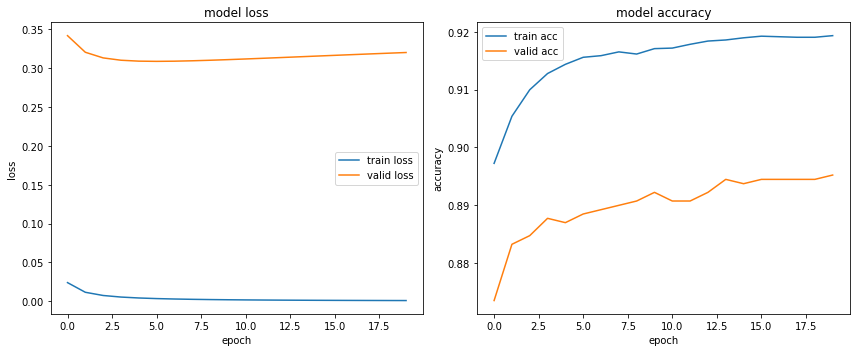

In [7]:
# 75. 損失と正解率のプロット
import matplotlib.pyplot as plt

def one_layer_net_learn2(max_epoch, lr, W):
    '''
    input :max_epoch, learning_late, W
    output:W, train_losses, train_accs, valid_losses, valid_accs
    '''
    # CrossEntropyLoss, SGDの用意
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD([W], lr)
    
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    for epoch in range(max_epoch):
        for i in range(len(X_train_float)):
            # lossの計算
            train_loss = loss(torch.matmul(X_train_float[i], W), Y_train_long[i])

            # 勾配の計算
            optimizer.zero_grad()
            train_loss.backward()

            # 更新
            optimizer.step()
        
        # loss, accの記録
        valid_loss = loss(torch.matmul(X_valid_float, W), Y_valid_long)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(measure_accuracy(X_train_float, Y_train_long, W))
        valid_accs.append(measure_accuracy(X_valid_float, Y_valid_long, W))
    
    return W, train_losses, train_accs, valid_losses, valid_accs

# Wの用意
fix_seed(42)
W_init = torch.rand(300, 4, requires_grad=True)

# ハイパーパラメータの設定
max_epoch = 20
lr = 0.1

# SGDによる学習
W_new, train_losses, train_accs, valid_losses, valid_accs = one_layer_net_learn2(max_epoch, lr, W_init)

# グラフにプロット
epoch = [i for i in range(max_epoch)]

train_losses_np = [train_loss.detach().numpy() for train_loss in train_losses]
valid_losses_np = [valid_loss.detach().numpy() for valid_loss in valid_losses]

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(epoch, train_losses_np, label='train loss')
ax1.plot(epoch, valid_losses_np, label='valid loss')
ax2.plot(epoch, train_accs, label='train acc')
ax2.plot(epoch, valid_accs, label='valid acc')
ax1.legend()
ax2.legend()
ax1.set_title('model loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2.set_title('model accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')

fig.tight_layout()
plt.show()

In [8]:
# 76. チェックポイント
def one_layer_net_learn3(max_epoch, lr, W):
    '''
    input :max_epoch, learning_late, W
    output:W(SGDによる学習, data/ch08/にチェックポイント書き出し)
    '''
    # CrossEntropyLoss, SGDの用意
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD([W], lr)
    
    for epoch in range(max_epoch):
        for i in range(len(X_train_float)):
            # lossの計算
            train_loss = loss(torch.matmul(X_train_float[i], W), Y_train_long[i])
            
            # 勾配の計算
            optimizer.zero_grad()
            train_loss.backward()
            
            # 更新
            optimizer.step()
        
        # チェックポイントの書き出し(5エポックごとに書き出し)
        if epoch % 5 == 4:
            fname = f'data/ch08/sgd_{epoch}.cpt'
            internal_states = {'epoch': epoch,
                               'SGD_state_dict': optimizer.state_dict(),
                               'W': W,
                               'W_grad': W.grad,
                              }
            torch.save(internal_states, fname)
    
    return W

# ハイパーパラメータの設定
max_epoch = 20
lr = 0.1

# Wの用意
fix_seed(42)
W_init = torch.rand(300, 4, requires_grad=True)

# SGDによる学習
W_new = one_layer_net_learn3(max_epoch, lr, W_init)

In [10]:
# 77. ミニバッチ化
import time

class TrainDataSet:
    def __init__(self):
        self.X = X_train_float
        self.Y = Y_train_long
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

def one_layer_net_learn4(max_epoch, lr, W, B):
    '''
    input :max_epoch, learning_late, W, B(bach_size)
    output:学習済みのW, 実行時間elapsed_time
    '''
    # 開始時間
    start_time = time.process_time()
    
    # ミニバッチ化
    train_data = TrainDataSet()
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=B, shuffle=True, drop_last=True)
    
    # CrossEntropyLoss, SGDの用意
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD([W], lr)
    
    for epoch in range(max_epoch):
        for X, Y in train_data_loader:
            # lossの計算
            Loss = loss(torch.matmul(X, W), Y)
            
            # 勾配の計算
            optimizer.zero_grad()
            Loss.backward()
            
            # 更新
            optimizer.step()
    
    # 終了時間, 経過時間
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    
    return W, elapsed_time

# ハイパーパラメータの設定
max_epoch = 20
lr = 0.1
Bs = [1,2,4,8,16]

# Wの用意
fix_seed(42)
W_init = torch.rand(300, 4, requires_grad=True)

# SGDによる学習
# B=1,2,4,8,16について検証データの正解率と経過時間を記録
elapsed_times = []
valid_accs = []

for B in Bs:
    W_new, elapsed_time = one_layer_net_learn4(max_epoch, lr, W_init, B)
    valid_accuracy = measure_accuracy(X_valid_float, Y_valid_long, W_new)
    elapsed_times.append(elapsed_time)
    valid_accs.append(valid_accuracy)

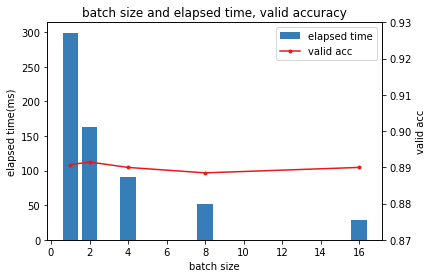

In [11]:
# グラフの描写
from matplotlib import cm

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# 色の設定
color_1 = cm.Set1.colors[1]
color_2 = cm.Set1.colors[0]

# accuracyとtimeのプロット
ax1.bar(Bs, elapsed_times, color=color_1, label='elapsed time')
ax2.plot(Bs, valid_accs, color=color_2, label='valid acc', marker='.')

ax1.set_ylabel('elapsed time(ms)')
ax2.set_ylabel('valid acc')
ax1.set_xlabel('batch size')
ax2.set_ylim(0.87, 0.93)

# 凡例をまとめて出力
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

ax1.legend(handler1+handler2, label1+label2)

plt.title('batch size and elapsed time, valid accuracy')
plt.show()

### GPU使用の準備

In [12]:
# GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# GPU上で正解率を計算
def measure_accuracy_gpu(x, y, W):
    '''
    input : x(特徴量行列, tensor), y(ラベルベクトル, tensor), W(重み行列, tensor)
    output: accuracy
    '''
    # 予測ラベルの計算
    predict_y = torch.max(torch.matmul(x, W), 1)[1]
    
    # 正解率の計算
    accuracy = sum(y == predict_y) / len(y)
    
    return accuracy

# 検証データをGPUに載せる
X_valid_float_gpu = X_valid_float.to(device)
Y_valid_long_gpu = Y_valid_long.to(device)

In [13]:
# 78. GPU上での学習
class GPUTrainDataSet:
    def __init__(self):
        self.X = X_train_float.to(device)
        self.Y = Y_train_long.to(device)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

def one_layer_net_learn5(max_epoch, lr, W, B):
    '''
    input :max_epoch, learning_late, W, B(bach_size)
    output:学習済みのW, 実行時間elapsed_time
    '''
    # 開始時間
    start_time = time.process_time()
    
    # ミニバッチ化
    gpu_train_data = GPUTrainDataSet()
    gpu_train_data_loader = torch.utils.data.DataLoader(gpu_train_data, batch_size=B, shuffle=True, drop_last=True)
    
    # CrossEntropyLoss, SGDの用意
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD([W], lr)
    
    for epoch in range(max_epoch):
        for X, Y in gpu_train_data_loader:
            # lossの計算
            Loss = loss(torch.matmul(X, W), Y)
            
            # 勾配の計算
            optimizer.zero_grad()
            Loss.backward()
            
            # 更新
            optimizer.step()
    
    # 終了時間, 経過時間
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    
    return W, elapsed_time

# ハイパーパラメータの設定
max_epoch = 20
lr = 0.1
Bs = [1,2,4,8,16]

# Wの用意(GPUに載せる)
fix_seed(42)
W_init = torch.rand(300, 4, requires_grad=True, device=device)

# SGDによる学習
# B=1,2,4,8,16について検証データの正解率と経過時間を記録
elapsed_times2 = []
valid_accs2_gpu = []

for B in Bs:
    W_new, elapsed_time = one_layer_net_learn5(max_epoch, lr, W_init, B)
    valid_accuracy = measure_accuracy_gpu(X_valid_float_gpu, Y_valid_long_gpu, W_new)
    elapsed_times2.append(elapsed_time)
    valid_accs2_gpu.append(valid_accuracy)

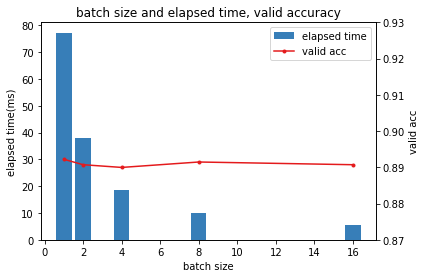

In [14]:
# グラフの描写
# データをcpu上に載せる
valid_accs2 = [valid_acc.cpu() for valid_acc in valid_accs2_gpu]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# 色の設定
color_1 = cm.Set1.colors[1]
color_2 = cm.Set1.colors[0]

# accuracyとtimeのプロット
ax1.bar(Bs, elapsed_times2, color=color_1, label='elapsed time')
ax2.plot(Bs, valid_accs2, color=color_2, label='valid acc', marker='.')

ax1.set_ylabel('elapsed time(ms)')
ax2.set_ylabel('valid acc')
ax1.set_xlabel('batch size')
ax2.set_ylim(0.87, 0.93)

# 凡例をまとめて出力
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

ax1.legend(handler1+handler2, label1+label2)

plt.title('batch size and elapsed time, valid accuracy')
plt.show()

In [18]:
# 79. 多層ニューラルネットワーク
class TwoLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300, 10)
        self.fc2 = nn.Linear(10, 4)
    
    # 順伝播
    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

def two_layer_net_learn(max_epoch=20, lr=0.1, B=16):
    '''
    input :max_epoch, learning_late, B(bach_size)
    output:valid_accuracys
    '''
    valid_accs = []
    
    # nnの用意
    fix_seed(42)
    two_layer_net = TwoLayerNet().to(device)
    
    # ミニバッチ化
    gpu_train_data = GPUTrainDataSet()
    gpu_train_data_loader = torch.utils.data.DataLoader(gpu_train_data, batch_size=B, shuffle=True, drop_last=True)
    
    # 目的関数の設定, SGD用意
    criterion = nn.functional.cross_entropy
    optimizer = optim.SGD(two_layer_net.parameters(), lr)
    
    for epoch in range(max_epoch):
        for X, Y in gpu_train_data_loader:
            # 順伝播の計算
            predict_Y = two_layer_net(X)
            Loss = criterion(predict_Y, Y)
            
            # 勾配の計算
            optimizer.zero_grad()
            Loss.backward()
            
            # 更新
            optimizer.step()
        
        # accuracyの計算
        predict_Y_valid = torch.argmax(two_layer_net(X_valid_float_gpu), dim=1)
        valid_acc = torch.sum(predict_Y_valid == Y_valid_long_gpu) * 1.0 / len(Y_valid_long_gpu)
        valid_accs.append(valid_acc)
    
    return valid_accs

# ハイパーパラメータの設定
max_epoch = 100
lr = 0.1
B = 32

# SGDによる学習
valid_accuracys_gpu = two_layer_net_learn(max_epoch, lr, B)

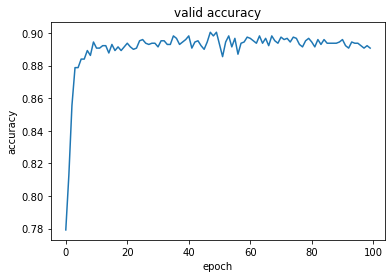

In [19]:
# グラフの描写
# データをcpu上に載せる
valid_accuracys_cpu = [valid_acc.cpu() for valid_acc in valid_accuracys_gpu]

epoch = [i for i in range(max_epoch)]

plt.plot(epoch, valid_accuracys_cpu)
plt.title('valid accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [20]:
# max accuracyとその時のepoch数
print(f'max accuracy: {np.max(valid_accuracys_cpu)}')
print(f'epoch: {np.argmax(valid_accuracys_cpu)}')

max accuracy: 0.9004491567611694
epoch: 47
